In [28]:
from dataclasses import dataclass
import amrex.space3d as amr
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib.animation import FFMpegWriter, FuncAnimation
from matplotlib.colors import Normalize
from IPython.display import display, Video

if not amr.initialized():
    amr.initialize([])

In [29]:
plt_directory = "/home/qfister/aa_Project/FHDeX/exec/immersed_boundary/taylor_line/new_plt_data"
plot_files = sorted([os.path.join(plt_directory, f) for f in os.listdir(plt_directory) if f.startswith('plt')])

In [30]:
@dataclass
class Particle:
    x: float
    y: float
    z: float
    ib_id: int
    idx: int

In [31]:
def load_particle_data(plt_file_name):
    plt = amr.PlotFileData(plt_file_name)
    probDomain = plt.probDomain(0)
    probLo = plt.probLo()
    probHi = plt.probHi()
    domain_box = amr.Box(probDomain.small_end, probDomain.big_end)
    real_box = amr.RealBox(probLo, probHi)
    std_geometry = amr.Geometry(domain_box, real_box, plt.coordSys(), [0, 0, 0])

    pc = amr.ParticleContainer_16_4_0_0_default(
        std_geometry,
        plt.DistributionMap(plt.finestLevel()),
        plt.boxArray(plt.finestLevel()),
    )
    pc.restart(plt_file_name, "immbdy_markers")

    particles = []
    for pti in pc.iterator(pc, level=plt.finestLevel()):
        aos = pti.aos()
        for p in aos.to_numpy(copy=True):
            particles.append(Particle(x=p[0], y=p[1], z=p[2], ib_id=int(p[-1]), idx=int(p[-2])))

    return particles, probLo, probHi

In [32]:
def load_pressure_data(plt_file_name):
    plt_data = amr.PlotFileData(plt_file_name)
    dom = plt_data.probDomain(0)
    box_size = [i + 1 for i in dom.hi_vect]
    center = [int(i / 2) for i in dom.hi_vect]
    mfab_pres = plt_data.get(0, "pres")
    pres_data = np.zeros(box_size)

    for mfi in mfab_pres:
        marr = mfab_pres.array(mfi)
        vb = mfi.validbox()
        lo = list(vb.lo_vect)
        hi = list(vb.hi_vect)
        data = marr.to_xp()[:, :, :, 0]
        pres_data[lo[0]:hi[0] + 1, lo[1]:hi[1] + 1, lo[2]:hi[2] + 1] = data

    return pres_data, center

In [33]:
def generate_frame(plt_filename):
    plt_data = amr.PlotFileData(plt_filename)
    dom = plt_data.probDomain(0)
    box_size = [i + 1 for i in dom.hi_vect]
    center = [int(i / 2) for i in dom.hi_vect]
    
    mfab_pres = plt_data.get(0, "pres")
    pres_data = np.zeros(box_size)
    for mfi in mfab_pres:
        marr = mfab_pres.array(mfi)
        vb = mfi.validbox()
        lo = list(vb.lo_vect)
        hi = list(vb.hi_vect)
        data = marr.to_xp()[:, :, :, 0]
        pres_data[lo[0]:hi[0] + 1, lo[1]:hi[1] + 1, lo[2]:hi[2] + 1] = data

    mfab_cc_forcex = plt_data.get(0, "cc_forcex")
    cc_forcex_data = np.zeros(box_size)
    for mfi in mfab_cc_forcex:
        marr = mfab_cc_forcex.array(mfi)
        vb = mfi.validbox()
        lo = list(vb.lo_vect)
        hi = list(vb.hi_vect)
        data = marr.to_xp()[:, :, :, 0]
        cc_forcex_data[lo[0]:hi[0] + 1, lo[1]:hi[1] + 1, lo[2]:hi[2] + 1] = data

    mfab_cc_forcey = plt_data.get(0, "cc_forcey")
    cc_forcey_data = np.zeros(box_size)
    for mfi in mfab_cc_forcey:
        marr = mfab_cc_forcey.array(mfi)
        vb = mfi.validbox()
        lo = list(vb.lo_vect)
        hi = list(vb.hi_vect)
        data = marr.to_xp()[:, :, :, 0]
        cc_forcey_data[lo[0]:hi[0] + 1, lo[1]:hi[1] + 1, lo[2]:hi[2] + 1] = data

    particles, probLo, probHi = load_particle_data(plt_filename)

    x_vals = [(p.x - probLo[0]) / (probHi[0] - probLo[0]) * pres_data.shape[0] for p in particles]
    y_vals = [(p.y - probLo[1]) / (probHi[1] - probLo[1]) * pres_data.shape[1] for p in particles]

    return np.transpose(pres_data[:, :, center[1]]), np.transpose(cc_forcex_data[:, :, center[1]]), np.transpose(cc_forcey_data[:, :, center[1]]), x_vals, y_vals

In [34]:
def update(frame):
    ax.clear()
    
    pres_frame, cc_forcex_frame, cc_forcey_frame, x_vals, y_vals = frame
    im = ax.matshow(pres_frame, cmap='twilight_r', norm=norm)
    X, Y = np.meshgrid(np.arange(pres_frame.shape[1]), np.arange(pres_frame.shape[0]))
    scale_factor = 0.1
    arrow_scale = 0.01
    quiver_scale = 3  

    ax.scatter(x_vals, y_vals, c='b', marker='o', s=20, alpha=0.6, edgecolors='w', linewidths=0.5)
    ax.quiver(X, Y, cc_forcex_frame * scale_factor * arrow_scale, cc_forcey_frame * scale_factor * arrow_scale, 
              color="red", angles='xy', scale_units='xy', width=0.004, scale=quiver_scale)
    
    return im

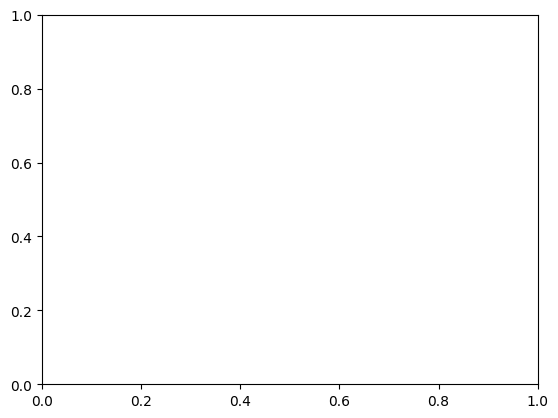

In [35]:
fig, ax = plt.subplots()
frames = [generate_frame(f) for f in plot_files]

In [36]:
norm = Normalize(vmin=np.min([f[0] for f in frames]), vmax=np.max([f[0] for f in frames]))
sm = plt.cm.ScalarMappable(cmap='twilight_r', norm=norm)
sm.set_array([])

In [37]:
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Pres (dyne/cm²)')

ani = FuncAnimation(fig, update, frames=frames, repeat=False)
output_video = os.path.join(plt_directory, "particles.mp4")
ani.save(output_video, writer=FFMpegWriter(fps=10))

display(Video(output_video, embed=True))